## Tandem visualization and post-processing
Author: Jeena Yun (j4yun@ucsd.edu)

Did you successfully run Tandem? Now, we will learn about how to process Tandem outputs such that we can produce useful plots showing different aspects of rupture history.

### Learning objectives
- Learn about output formats of Tandem
- Learn about how to visualize outputs at different time and depth
- Learn about the effects of changing material properties on the rupture characteristics

### Contents

- [Understand fault probe outputs](#Understand-fault-probe-outputs)
- [Prepare for plotting: load packages and define path to the outputs](#Prepare-for-plotting:-load-packages-and-define-path-to-the-outputs)
- [Plot time series of a variable on an individual fault probe](#Plot-time-series-of-a-variable-on-an-individual-fault-probe)
- [Plot spatiotemporal evolution of slip rate](#Plot-spatiotemporal-evolution-of-slip-rate)
- [Compare two models](#Compare-two-models)
    - [Compare shear moduli ($\mu$)](#Compare-shear-moduli-($\mu$))
    - [Compare spatiotemporal evolution of slip rates](#Compare-spatiotemporal-evolution-of-slip-rates)
    - [Compare peak slip rates](#Compare-peak-slip-rates)
- [(Bonus) Plot spatiotemporal evolution of cumulative slip](#(Bonus)-Plot-spatiotemporal-evolution-of-cumulative-slip)

## Understand fault probe outputs

Before we jump into plotting anything, let's learn about Tandem fault probe outputs.

In the parameter file, we provided **'name'** and **'location'** of on-fault probes. For example, in your `bp3.toml` file, you'll see:
```
[fault_probe_output]
prefix = "outputs/fltst_"
t_max = 9460800
probes = [
    { name = "dp000", x = [0.0, -0.0] },
    { name = "dp001", x = [1.0, -0.57735027] },
    ...
    { name = "dp029", x = [29.0, -16.74315781] },
    { name = "dp030", x = [30.0, -17.32050808] }
]
```
As a result, you'll see files `fltst_dp000.csv`, `fltst_dp001.csv`, ..., `fltst_dp030.csv`, under `outputs` directory.

Each probe (or each csv file) will record the following variables (in 2D):
| Name               | Column Index | Description                                                            | Unit |
|--------------------|--------------|------------------------------------------------------------------------|------|
| **Time**           | 0            | Time at which the output is written                                    | s    |
| **state**          | 1            | State variable $\phi = f_0 + b \ln{\left(V_0 \theta / L\right)}$       | -    |
| **slip0**          | 2            | Fault slip                                                             | m    |
| **traction0**      | 3            | Shear traction on the fault                                            | MPa  |
| **slip-rate0**     | 4            | Slip rate on the fault                                                 | m/s  |
| **normal-stress**  | 5            | Normal stress on the fault                                             | MPa  |

Now, we know how the fault probe output looks like. Let's make some figures.

## Prepare for plotting: load packages and define path to the outputs

Let's first find where your output lives. All the job outputs you ran through the gateway are accessible through this **Jupyter Notebook Expanse** app.

First, check your current location:

In [1]:
!pwd                          # putting ! in the front is equivalent to typing ls in terminal

/opt/notebooks/visualization_1/tandem-training/quakeworx-jan-2025/visualization


You will see you are at `/opt/notebooks/{YOUR_JOB_NAME}/tandem-training/quakeworx-jan-2025/visualization`.

`/opt/notebooks` is the system directory where all your jobs are stored, `{YOUR_JOB_NAME}` is the job name you chose to open the **Jupyter Notebook Expanse** app, and `tandem-training/quakeworx-jan-2025/visualization` is the structure of the Github repository you just cloned. 

You can check all the job names you have submitted so far:

In [2]:
!ls /opt/notebooks             # list all job names

SeisSol			       Tandem_training_test_highres_2  visualization
Tandem_depthVarying	       Tandem_uniform		       visualization_1
Tandem_depth_varying_r_2       tpv33_lowres
Tandem_depth_varying_r_5GPa_2  training_tpv13


Using the information shown above, define the path to your Tandem output.

In [3]:
import os

# Replace TANDEM_JOB_NAME with the job name you used to run your uniform shear modulus Tandem model
# e.g., save_dir = os.path.join('/opt/notebooks','Tandem_uniform')
save_dir = os.path.join('/opt/notebooks','TANDEM_JOB_NAME')      # make sure your job name is in '', making it a python string

Then, load python packages that are commonly used throughout this notebook

In [4]:
import numpy as np                       # contains a number of useful functions
import pandas as pd                      # efficiently loads csv files
import matplotlib.pyplot as plt          # essential for plotting 

yr2sec = 365*24*60*60               # A year in seconds; useful when plotting Tandem simulations of thousands of years
plt.rcParams['font.size'] = '15'    # Define default font size for plots

Now, we are ready to plot Tandem outputs!

## Plot time series of a variable on an individual fault probe

We will start by making a simple time series plot of a variable,by reading one of the csv files.

For example, let's read outputs from probe `fltst_dp011.csv`.

In [5]:
# Define target csv file name
fname = os.path.join(save_dir,'outputs','fltst_dp011.csv')

# Read csv file using pandas package
# Each field is separated by commas, so use delimiter=','
# Skip the first row, which is a comment showing the probe location, to keep the header information
dat = pd.read_csv(fname, delimiter=',', skiprows=1)

All the variables are accessible using the header name. For example, if you want to check the slip output, run:

In [6]:
print(dat['slip0'])

0         0.000000
1         0.000016
2         0.000016
3         0.000016
4         0.000016
           ...    
23037    13.841712
23038    13.844503
23039    13.847306
23040    13.850197
23041    13.853022
Name: slip0, Length: 23042, dtype: float64


It is useful to keep track of the probe location by reading the first row of the csv file:

In [7]:
# Save station location by reading only the first row
probeloc_str = pd.read_csv(fname, nrows=1, header=None).values # the first row is saved as a string

# Extract x and y location of the probe from the string
probe_x,probe_y = float(probeloc_str[0][0].split('[')[-1]),float(probeloc_str[0][-1].split(']')[0])

# Print probe location
print('Probe located at x = [%1.4f, %1.4f]'%(probe_x,probe_y))

Probe located at x = [11.0000, -6.3509]


Now, let's plot time series of slip rate and shear traction. Slip rate has a wide range of values, so it is useful to plot in log10 scale:

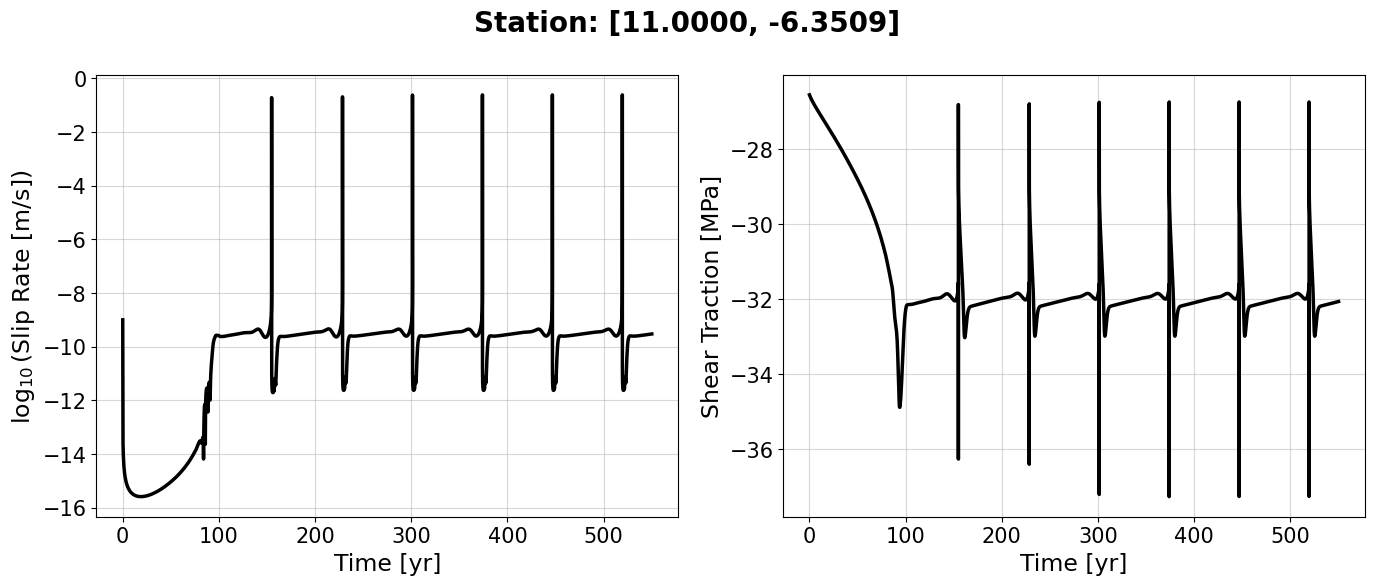

In [8]:
# Plot time-series
fig, [ax,ax2] = plt.subplots(ncols=2, figsize = (14,6))

ax.plot(dat['Time']/yr2sec, np.log10(abs(dat['slip-rate0'])), color='k', lw=2.5)
ax.set_xlabel('Time [yr]', fontsize=17)
ax.set_ylabel(r'$\log_{10}$(Slip Rate [m/s])', fontsize=17)
ax.grid(True, alpha=0.5)

ax2.plot(dat['Time']/yr2sec, dat['traction0'], color='k', lw=2.5)
ax2.set_xlabel('Time [yr]', fontsize=17)
ax2.set_ylabel('Shear Traction [MPa]', fontsize=17)
ax2.grid(True, alpha=0.5)

fig.suptitle('Station: [%1.4f, %1.4f]'%(probe_x,probe_y), fontsize=20, fontweight = 'bold')
plt.tight_layout()
plt.show()

## Plot spatiotemporal evolution of slip rate

How about plotting the spatiotemporal evolution of variables along the entire fault? 

To do this, we need to save all outputs from all probes into a single array. The function below will read all fault probe outputs and save them into a numpy array.

In [9]:
from glob import glob     # enables global search on fault probe outputs

def load_fault_probe_outputs(save_dir):
    # Search all fault probe outputs
    fnames = glob(os.path.join(save_dir,'outputs','fltst_*.csv'))

    print('Start computing output... ',end='')
    # Iteratively read all csv files and append data and station locations into an empty array 
    # The resulting array will have a dimension of (# probes, # time steps, # variables (=6))
    outputs,dep=[],[]
    for fname in np.sort(fnames):
        # Read and append data
        dat = pd.read_csv(fname, delimiter=',', skiprows=1)
        outputs.append(dat.values)

        # Read and append station depth information
        probeloc_str = pd.read_csv(fname, nrows=1, header=None)
        dep.append(float(probeloc_str.values[0][-1].split(']')[0]))

    # Convert to numpy array for convenience
    outputs = np.array(outputs)
    dep = np.array(dep)

    # Sort the array by depth and 
    ii = np.argsort(abs(dep))
    outputs = outputs[ii,:,:]
    dep = dep[ii]
    print('Done!')

    return outputs, dep

With this array, we can extract, e.g, slip rate, for all depths and time steps

In [10]:
# Compute array output
outputs,dep = load_fault_probe_outputs(save_dir)

# Check size of the array output
print('Size of the array output:',outputs.shape)

# Extract slip rate from the array output
sr = outputs[:,:,4]       # slip rate is in 4th column

# Check size of the slip rate output
print('Size of the slip rate output:',sr.shape)

Start computing output... Done!
Size of the array output: (31, 23042, 6)
Size of the slip rate output: (31, 23042)


Confirm that size of the array output is (# probes, # time steps, # variables (=6)), whereas specific variable has size of (# probes, # time steps)

To plot the slip rate as a 2D image, we need a meshgrid of x- (time step) and y- (depth) coordinates:

In [11]:
xax = np.arange(sr.shape[1])   # define x-axis as time steps
X,Y = np.meshgrid(xax,abs(dep))      # use meshgrid to combine x- and y- coordinates

Here, we import the colormap I specifically put together to make slip rate plots that better capture different rupture speeds:
- Red: coseismic slip rate
- Yellow: aseismic slip rate comparable to the reference slip rate (V0)
- Blue: stable creep of about plate loading rate (Vp)
- Black: locked

Like before, we are plotting the slip rate in log10 scale to see a wide spectrum of velocities.

In [12]:
from cmap_for_sliprate import auto_cmap_for_sliprate
cmap, norm = auto_cmap_for_sliprate()

Using this colormap, we obtain a plot of spatiotemporal evolution of slip rate

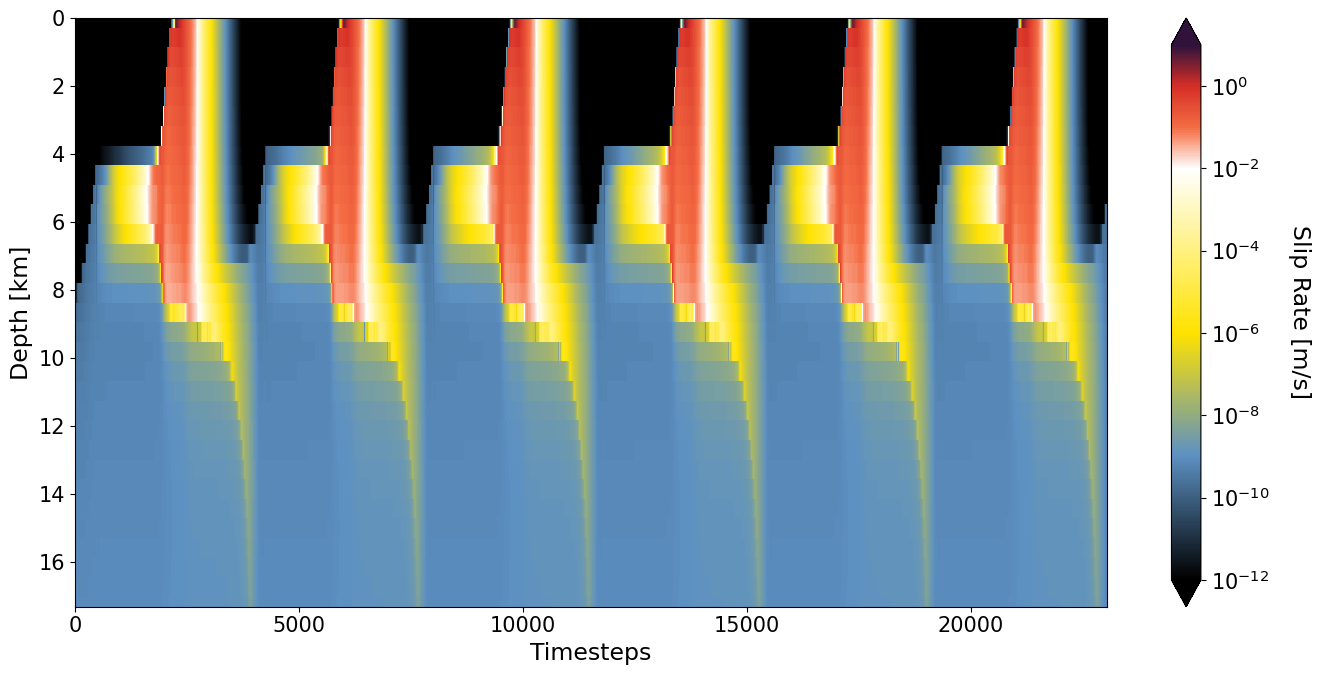

In [13]:
fig,ax=plt.subplots(figsize=(14,7)) # figure size
    
cb = plt.pcolormesh(X, Y, abs(sr), cmap=cmap, norm=norm)    
plt.colorbar(cb,extend='both').set_label('Slip Rate [m/s]',fontsize=17,rotation=270,labelpad=30) # vertical colorbar

plt.xlabel('Timesteps',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(0,np.max(X))
plt.ylim(np.max(abs(Y)),0)

plt.tight_layout()

Spatiotemporal evolution of slip rate is one of the most commonly used ways of visualizing the rupture history of SEAS models. This plot clearly shows stable creep at deeper part of the fault, six seismic ruptures, and their afterslip.

## Compare two models

A moment ago, we ran two models, one with a uniform shear modulus and the other with a depth-varying shear modulus $\mu$.

We will now learn how to compare material properties and resulting peak slip rate from different models.

First, define output path to the depth-varying $\mu$ model, as we did [above](#Prepare for plotting: load packages and define path to the-outputs)

In [14]:
# Replace DEPVAR_JOB_NAME with the job name you used to run your Tandem model
# e.g., save_dir_depvar = os.path.join('/opt/notebooks','Tandem_depthVarying')
save_dir_depvar = os.path.join('/opt/notebooks','DEPVAR_JOB_NAME')      # make sure your job name is in '', making it a python string

### Compare shear moduli ($\mu$)

The functions defined in `.lua` file can be called in python using `LuaRuntime` from a package called `lupa`: 

In [15]:
from lupa import LuaRuntime

# Define a function to call from Lua file
def load_from_lua(save_dir):
    # Initiate Lua callback
    lua = LuaRuntime()

    # Open and read Lua file
    with open(os.path.join(save_dir,'bp3.lua'), "r") as f:    # you can change the name of lua file later
        lua_code = f.read()
    lua.execute(lua_code)                       # execute lines in Lua

    # 2. Access a specific scenario
    # First, check which scenario you used in your toml file
    # E.g., line 4 in bp3.toml: scenario = "bp3_d30_reverse"
    scenario = lua.globals().bp3_d30_reverse         # 'bp3_d30_reverse' is the name of the scenario we defined in the lua file
    return scenario

Now, load the scenairo information for each model:

In [16]:
# Read lua files for both models
scenario = load_from_lua(save_dir)
scenario_depvar = load_from_lua(save_dir_depvar)

The variables and functions defined in each scenario can be executed: E.g.,

In [17]:
print('amax =',scenario.amax) # constant 'amax' in the uniform mu model
print('mu(0,10) =',scenario.mu(scenario,0,10),'(uniform mu)') # function 'mu(x,y)' in the uniform mu model, executed at (x,y) = (0,10)
print('mu(0,10) =',scenario_depvar.mu(scenario_depvar,0,10),'(depth-varying mu)') # function 'mu(x,y)' in the depth-varying mu model, executed at (x,y) = (0,10)

amax = 0.025
mu(0,10) = 46.39999984302253 (uniform mu)
mu(0,10) = 36.78287502030364 (depth-varying mu)


Let's use this Lua callback to plot spatial distributions of $\mu$ in both models.

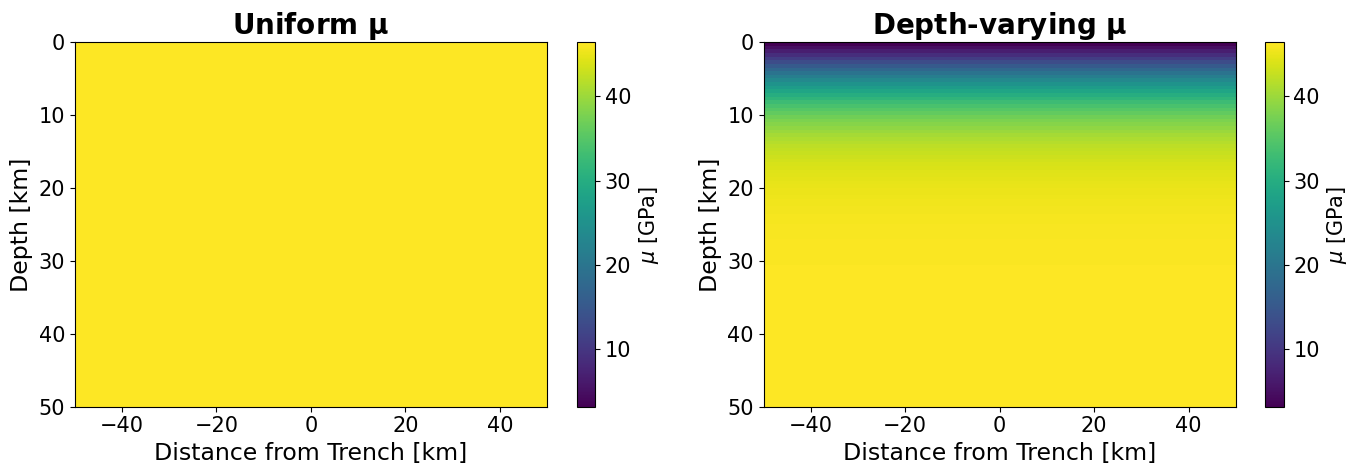

In [18]:
# Set depth and distance ranges
depth = np.linspace(0, 50, 100)  # 100 points from 0 to 50
distance = np.linspace(-50, 50, 100)  # 100 points from -50 to 50

# Compute mu values in a double loop
mu = np.zeros((len(depth), len(distance)))            # empty array to save mu values (for uniform)
mu_depvar = np.zeros((len(depth), len(distance)))     # empty array to save mu values (for depth-varying)
for i, depth_i in enumerate(depth):
    for j, distance_j in enumerate(distance):
        mu[i, j] = scenario.mu(scenario, distance_j, depth_i)  # direct call into Lua
        mu_depvar[i, j] = scenario_depvar.mu(scenario_depvar, distance_j, depth_i)


# Plot results using imshow
fig, [ax,ax2] = plt.subplots(ncols=2, figsize=(14, 5))  # initiate a plot with two panels

# Panel 1. Unifrom mu
# We will use the same vmin & vmax for both panels for direct comparison
im = ax.imshow(mu, extent=[distance.min(), distance.max(), depth.max(), depth.min()], aspect='auto', vmin=np.min(mu_depvar), vmax=np.max(mu_depvar))
plt.colorbar(im,ax=ax,label=r'$\mu$ [GPa]')
ax.set_xlabel('Distance from Trench [km]', fontsize=17)
ax.set_ylabel('Depth [km]', fontsize=17)
ax.set_title(r'Uniform $\bf\mu$', fontsize=20, fontweight='bold')

# Panel 2. Depth-varying mu
im = ax2.imshow(mu_depvar, extent=[distance.min(), distance.max(), depth.max(), depth.min()], aspect='auto', vmin=np.min(mu_depvar), vmax=np.max(mu_depvar))
plt.colorbar(im,ax=ax2,label=r'$\mu$ [GPa]')
ax2.set_xlabel('Distance from Trench [km]', fontsize=17)
ax2.set_ylabel('Depth [km]', fontsize=17)
ax2.set_title(r'Depth-varying $\bf\mu$', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

### Compare spatiotemporal evolution of slip rates

We checked how to visualize differences in the material properties. Now, let's see how these differences in material properties affect the rupture dynamics.

We will plot the spatiotemporal variation of slip rate for the depth-varying $\mu$ model, and compare it with the uniform $\mu$ model result.

To do that, let's first compute the peak slip rate using the array output. Compute the array output of the depth-varying $\mu$ model using the `load_fault_probe_outputs` function we defined above

In [19]:
# Compute array outputs for depth-varying mu model as well
outputs_depvar, dep_depvar = load_fault_probe_outputs(save_dir_depvar)

# Extract slip rates
sr_depvar = abs(outputs_depvar[:,:,4])

Start computing output... Done!


Then, plot the slip rate evolution, following the same procedure in [[Plot spatiotemporal evolution of slip rate]](#Plot-spatiotemporal-evolution-of-slip-rate).

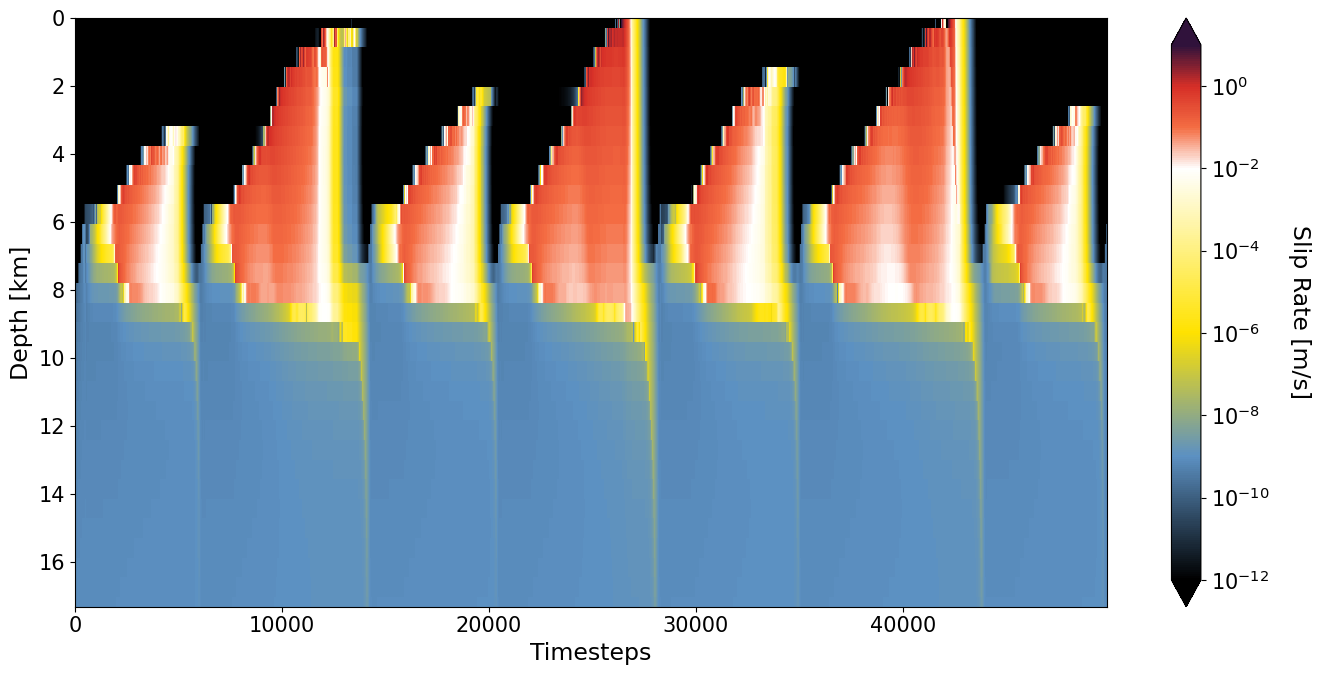

In [20]:
# Define x- and y- coordinates
xax = np.arange(sr_depvar.shape[1])   # define x-axis as time steps
X,Y = np.meshgrid(xax,abs(dep_depvar))      # use meshgrid to combine x- and y- coordinates

# Define custom colormap
from cmap_for_sliprate import auto_cmap_for_sliprate
cmap, norm = auto_cmap_for_sliprate()

# Plot using pcolormesh
fig,ax=plt.subplots(figsize=(14,7)) # figure size
    
cb = plt.pcolormesh(X, Y, sr_depvar, cmap=cmap, norm=norm)    
plt.colorbar(cb,extend='both').set_label('Slip Rate [m/s]',fontsize=17,rotation=270,labelpad=30) # vertical colorbar

plt.xlabel('Timesteps',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(0,np.max(X))
plt.ylim(np.max(abs(Y)),0)

plt.tight_layout()

Compare this result with that in section [[Plot spatiotemporal evolution of slip rate]](#Plot-spatiotemporal-evolution-of-slip-rate). Do you see the difference? 

In this depth-varying $\mu$ model, partial ruptures emerge, in contrast to the uniform $\mu$ model where only system-size ruptures are observed. Also, one more earthquake occurs compared to the uniform $\mu$ model within the same simulation time, indicating a shorter recurrence interval. 

### Compare peak slip rates

In addition, comparing peak slip rate is a good way to understand differences in slip rate and recurrence intervals.

We want to compute the peak slip rate along depth for each time step. This can be done by using the `np.max` function with appropriate `axis` argument:

In [21]:
# Compute peak slip rate along the entire fault
psr = np.max(sr,axis=0)
psr_depvar = np.max(sr_depvar,axis=0)

# Check size of the peak slip rate output
print('Size of the peak slip rate output:',psr.shape)

Size of the peak slip rate output: (23042,)


You will see that the peak slip rate output has a correct size equal to the number of time steps. Then, plot the two model results together to compare the difference.

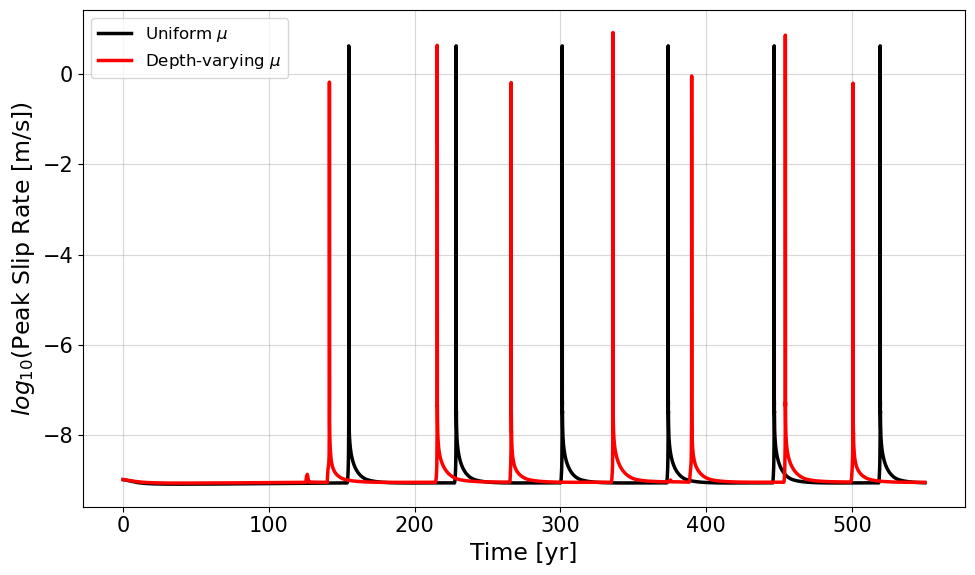

In [22]:
# Plot time-series
plt.figure(figsize = (10,6))
plt.plot(outputs[0,:,0]/yr2sec, np.log10(psr), color='k', lw=2.5, label=r'Uniform $\mu$') # outputs[0,:,0] contains time information at the surface
plt.plot(outputs_depvar[0,:,0]/yr2sec, np.log10(psr_depvar), color='r', lw=2.5, label=r'Depth-varying $\mu$')
plt.xlabel('Time [yr]', fontsize=17)
plt.ylabel('$log_{10}$(Peak Slip Rate [m/s])', fontsize=17)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Partial rupture earthquakes show smaller peak slip rates whereas the system-size earthquakes show larger peak slip rates compared to the uniform $\mu$ model. 

These comparisons show that the difference in $\mu$ affects rupture characteristics, such as rupture extent, recurrence interval, and peak slip rate during each earthquake.

## (Bonus) Plot spatiotemporal evolution of cumulative slip

Well done to all of you, who successfully followed the tutorial! You're now ready to visualize various aspects of your model. For those of you who are interested more in SEAS models, I'm leaving a bonus script here.

Plotting the spatiotemporal evolution of cumulative slip is another common practice to understand the rupture evolution of SEAS models. I provided a script to create such a plot.

The following script will plot coseismic slip evolution (in pink) and interseismic slip evolution (in grey) along the entire fault. The slip evolution is expressed by slip contours, plotted every given `dt_coseismic` seconds (coseismic) and `dt_creep` years (interseismic).

Remove single-depth activated event: []


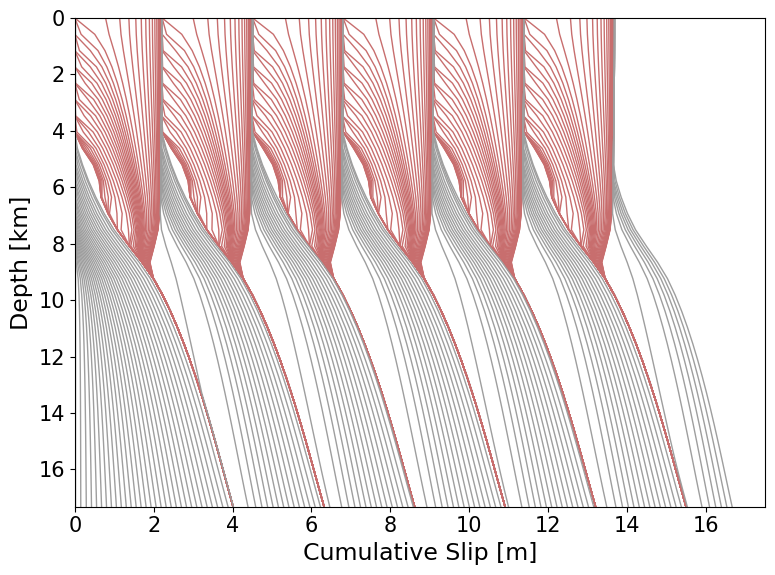

In [23]:
# Define input parameters
Vths = 1e-2                   # Slip rate threshold defining coseismic rupture [m/s]
dt_creep = 5                  # Time interval for interseismic slip contour [yr]
dt_coseismic = 0.5            # Time interval for coseismic slip contour [s]

# Compute cumulative slip outputs
from cumslip_plot import compute_cumslip
cumslip_outputs = compute_cumslip(outputs,dep,Vths,dt_creep*yr2sec,dt_coseismic,print_on=True)

# Plot
fig,ax = plt.subplots(figsize = (8,6))
ax.plot(cumslip_outputs['cscoseis'], cumslip_outputs['depcoseis'], color=(200/255,110/255,110/255), lw=1)
ax.plot(cumslip_outputs['cscreep'], cumslip_outputs['depcreep'], color='0.62', lw=1)
ax.set_xlabel('Cumulative Slip [m]', fontsize=17)
ax.set_ylabel('Depth [km]', fontsize=17)
xl = ax.get_xlim()
ax.set_xlim(0,xl[1])
ax.set_ylim(max([np.max(np.absolute(cumslip_outputs['depcoseis'])),np.max(np.absolute(cumslip_outputs['depcreep']))]),0)
plt.tight_layout()
plt.show()